In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from IPython.display import display, Image

## 0. Start Chromedriver
- **`CHROME_VERSION`**: go to your chrome settings and check your version of chrome. If your version does not match the version shown below, download the correct version of the Chromedriver from [here](https://chromedriver.chromium.org/downloads) and append the version number to the end of its name. e.g. if you have Chrome version 80, you should rename `chromedriver.exe` to `chromedriver80.exe`
  - **`Options()`**: adding `headless` and `window-size` arguments allows us to use Chromedriver without a GUI.

In [2]:
CHROME_VERSION='79'  # change this to match Chrome version on host machine

options = Options()
options.add_argument('headless')
options.add_argument('window-size=1200x600')
driver = webdriver.Chrome(f'./chromedriver/chromedriver{CHROME_VERSION}', options=options)

---
## 1. Load upcoming Super Rugby match odds

In [3]:
driver.get( "https://www.oddsportal.com/rugby-union/world/super-rugby/")
driver.implicitly_wait(5)  # give page time to load all content

We can take a peek at what the Chromedriver sees using the `get_screenshot_as_png()` method on the driver object.

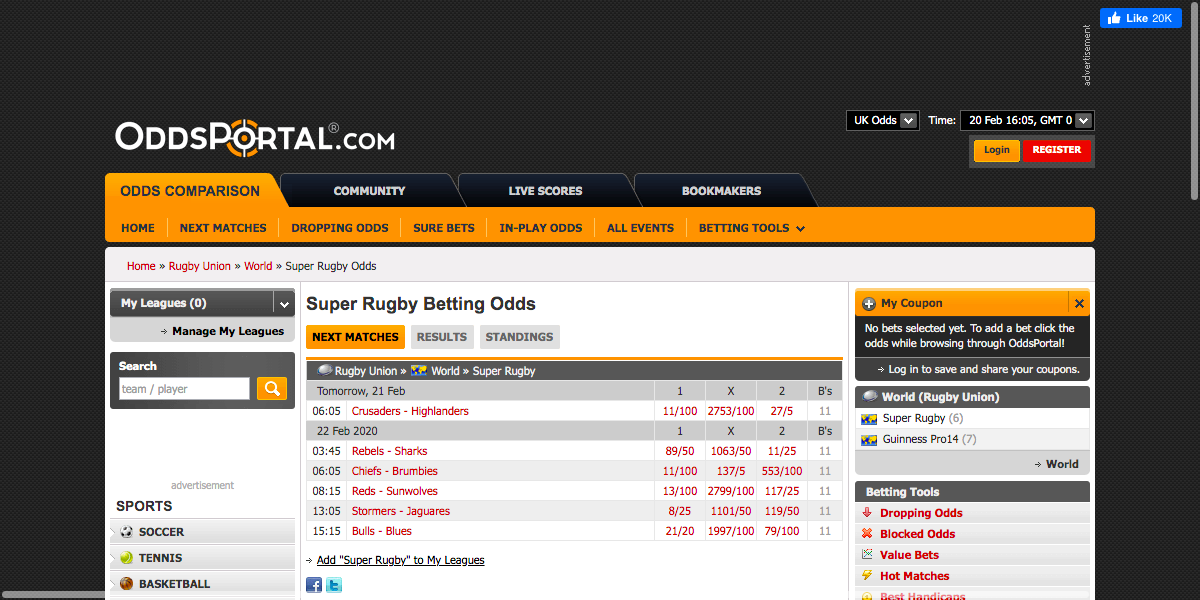

In [4]:
display(
    Image(
        driver.get_screenshot_as_png(),
        width=800,
        height=400
    )
)

In [5]:
table = driver.find_element_by_xpath('//*[@id="tournamentTable"]')

In [6]:
table.find_elements_by_xpath('//*[@id="tournamentTable"]/tbody/tr[7]')

[<selenium.webdriver.remote.webelement.WebElement (session="f94209aee9f6017f469a88429b9a4ff7", element="351cbcbe-85a1-435d-b055-8a3d8e75ea7a")>]

In [7]:
table.text

"Rugby Union\n»\n World\n»\nSuper Rugby\nTomorrow, 21 Feb 1 X 2 B's\n06:05 Crusaders - Highlanders\n11/100\n2753/100\n27/5\n11\n22 Feb 2020 1 X 2 B's\n03:45 Rebels - Sharks\n89/50\n1063/50\n11/25\n11\n06:05 Chiefs - Brumbies\n11/100\n137/5\n553/100\n11\n08:15 Reds - Sunwolves\n13/100\n2799/100\n117/25\n11\n13:05 Stormers - Jaguares\n8/25\n1101/50\n119/50\n11\n15:15 Bulls - Blues\n21/20\n1997/100\n79/100\n11"

In [8]:
table_rows = table.text.split('\n')
table_rows[:25]

['Rugby Union',
 '»',
 ' World',
 '»',
 'Super Rugby',
 "Tomorrow, 21 Feb 1 X 2 B's",
 '06:05 Crusaders - Highlanders',
 '11/100',
 '2753/100',
 '27/5',
 '11',
 "22 Feb 2020 1 X 2 B's",
 '03:45 Rebels - Sharks',
 '89/50',
 '1063/50',
 '11/25',
 '11',
 '06:05 Chiefs - Brumbies',
 '11/100',
 '137/5',
 '553/100',
 '11',
 '08:15 Reds - Sunwolves',
 '13/100',
 '2799/100']

In [9]:
# remove table header (first 5 lines)
table_rows = table_rows[5:]

In [10]:
# split list up by dates
date_idx = []
idx = 0
for row in table_rows:
    if "1 X 2 B's" in row:
        print(row)
        date_idx.append(idx)
    idx += 1

Tomorrow, 21 Feb 1 X 2 B's
22 Feb 2020 1 X 2 B's


In [11]:
date_idx

[0, 6]

In [12]:
# schema of dataframe
df = {
    'Date': [],
    'Home Team': [],
    'Away Team': [],
    'Home Score': [],
    'Away Score': [],
    'Play-off Game?': [],
    'Home Odds': [],
    'Draw Odds': [],
    'Away Odds': [],
    'Bookmakers Surveyed': []
}

# for each separate date
for i in range(len(date_idx)):
    
    # extract date
    date = table_rows[date_idx[i]]
    date = date.replace(" 1 X 2 B's", '')
    
    # remove unnecessary text
    if 'Tomorrow' in date or 'Today' in date:
        date = date[date.find(',')+2: ] + ' ' + str(datetime.datetime.now().year)
        
    date = date.replace(' ', '-')
    
    first_match = date_idx[i]+1
    
    fixtures = []
    
    if i < len(date_idx)-1:
        last_match = date_idx[i+1]
        fixtures = table_rows[first_match:last_match]
        
    else:
        fixtures = table_rows[first_match:]
        
    fixtures = np.array(fixtures).reshape(-1, 5)
    date_col = np.repeat([date], fixtures.shape[0])
    fixtures = np.hstack((date_col.reshape(-1, 1), fixtures))
    
    # add each row to dictionary
    for f in fixtures:
        df['Date'].append(f[0])
        df['Home Team'].append(f[1])
        df['Away Team'].append(f[1])
        df['Home Score'].append(0)
        df['Away Score'].append(0)
        df['Play-off Game?'].append('')
        df['Home Odds'].append(f[2])
        df['Draw Odds'].append(f[3])
        df['Away Odds'].append(f[4])
        df['Bookmakers Surveyed'].append(f[-1])

# convert dictionary to dataframe
df = pd.DataFrame(df)
df.head(7)

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,21-Feb-2020,06:05 Crusaders - Highlanders,06:05 Crusaders - Highlanders,0,0,,11/100,2753/100,27/5,11
1,22-Feb-2020,03:45 Rebels - Sharks,03:45 Rebels - Sharks,0,0,,89/50,1063/50,11/25,11
2,22-Feb-2020,06:05 Chiefs - Brumbies,06:05 Chiefs - Brumbies,0,0,,11/100,137/5,553/100,11
3,22-Feb-2020,08:15 Reds - Sunwolves,08:15 Reds - Sunwolves,0,0,,13/100,2799/100,117/25,11
4,22-Feb-2020,13:05 Stormers - Jaguares,13:05 Stormers - Jaguares,0,0,,8/25,1101/50,119/50,11
5,22-Feb-2020,15:15 Bulls - Blues,15:15 Bulls - Blues,0,0,,21/20,1997/100,79/100,11


In [14]:
def get_home(s):
    '''find the text between the kick-off time and the dash'''
    return re.search(r'[0-2][0-9]:[0-6][0-9](.*?)-', s).group(1).strip()

def get_away(s):
    '''find the last word of text'''
    return s.split()[-1]

def convert(odds):
    try: 
        output = float(odds)
    
    except:
        nom = int(odds.split("/")[0])
        dem = int(odds.split("/")[1])
        output = (nom/dem)+1
    return output

print(get_home('06:05 Blues - Chiefs'))
print(get_away('06:05 Blues - Chiefs'))

Blues
Chiefs


In [15]:
df['Home Team'] = df['Home Team'].apply(get_home)
df['Away Team'] = df['Away Team'].apply(get_away)

df['Home Odds'] = df['Home Odds'].apply(convert)
df['Away Odds'] = df['Away Odds'].apply(convert)
df['Draw Odds'] = df['Draw Odds'].apply(convert)

df.head(7)

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,21-Feb-2020,Crusaders,Highlanders,0,0,,1.11,28.53,6.40,11
1,22-Feb-2020,Rebels,Sharks,0,0,,2.78,22.26,1.44,11
2,22-Feb-2020,Chiefs,Brumbies,0,0,,1.11,28.40,6.53,11
3,22-Feb-2020,Reds,Sunwolves,0,0,,1.13,28.99,5.68,11
4,22-Feb-2020,Stormers,Jaguares,0,0,,1.32,23.02,3.38,11
5,22-Feb-2020,Bulls,Blues,0,0,,2.05,20.97,1.79,11


## Fetch Existing Dataset

In [60]:
# read in existing data
existing_dataset = pd.read_csv('super_rugby_oddsportal.csv')

# replace NaNs with empty strings
existing_dataset.fillna('', inplace=True)

existing_dataset.head()

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,07-Feb-20,Highlanders,Sharks,0,0,,1.39,22.61,3.01,11
1,07-Feb-20,Brumbies,Rebels,0,0,,1.38,23.09,3.08,11
2,08-Feb-20,Chiefs,Crusaders,0,0,,1.98,22.72,1.83,10
3,08-Feb-20,Waratahs,Blues,0,0,,1.98,20.86,1.85,11
4,08-Feb-20,Lions,Reds,0,0,,1.53,23.66,2.50,10


## Add Scraped Odds to Existing Dataset

In [65]:
# add new odds to existing
combined_df = pd.concat([df, existing_dataset], ignore_index=True)

In [66]:
combined_df.head()

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,14-Feb-2020,Blues,Crusaders,0,0,,3.47,24.74,1.31,11
1,14-Feb-2020,Rebels,Waratahs,0,0,,1.61,20.81,2.35,11
2,15-Feb-2020,Sunwolves,Chiefs,0,0,,9.49,40.78,1.05,11
3,15-Feb-2020,Hurricanes,Sharks,0,0,,1.31,24.35,3.41,11
4,15-Feb-2020,Brumbies,Highlanders,0,0,,1.44,22.14,2.78,11


In [67]:
combined_df.shape

(1366, 10)

## Save Updated Dataset to CSV

In [68]:
combined_df.to_csv('super_rugby_oddsportal.csv', index=False)